In [16]:
import numpy as np

from finquant.portfolio import *
from finquant.moving_average import compute_ma, ema

import pandas as pd
import datetime

import yfinance as yf

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import black_litterman, risk_models
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier, objective_functions

import riskfolio.Portfolio as pf

import matplotlib as plt
import matplotlib.pyplot as pyplt

import statsmodels .api  as  sm 
from sklearn.linear_model  import  LinearRegression
import cvxpy  as  cv
from scipy.stats import norm
from yahoo_fin.stock_info import *

In [2]:
df_health = pd.read_csv('tick_score_health.csv')
df_tech = pd.read_csv('tick_score_tech.csv')
df_durable = pd.read_csv('tick_score_durable.csv')
df_nondurable = pd.read_csv('tick_score_nondurable.csv')
df_capital = pd.read_csv('tick_score_capital.csv')
df_transport = pd.read_csv('tick_score_transport.csv')
df_util = pd.read_csv('tick_score_util.csv')
df_services = pd.read_csv('tick_score_services.csv')
df_energy = pd.read_csv('tick_score_energy.csv')
df_finance = pd.read_csv('tick_score_finance.csv')
df_basics = pd.read_csv('tick_score_basics.csv')


frames = [df_finance, df_capital, df_durable, df_energy, df_health, df_nondurable, df_services, df_tech, df_services, df_util, df_basics]
df = pd.concat(frames)
df = df.drop_duplicates(subset=['Unnamed: 0'], keep='last')
df = df.set_index("Unnamed: 0")

percentile = np.percentile(df['Score'], 90)
mu, std = norm.fit(df['Score'])
roc = std / 3
aplus = df[df['Score'] > mu + (roc*4)]
#aplus = df[df['Score'] > mu + (roc*6)]
tickers = list(aplus.index)

In [3]:
start = "2016-01-01"
end = "2020-12-30"
#future_end = "2020-12-30"

In [4]:
# Tickers of assets
assets = list(tickers)
assets.sort()

In [5]:
data = yf.download(assets, start = start, end = end, threads = False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

market_data = yf.download("^GSPC", start = start, end=end, threads = False)
market_data = market_data.loc[:,('Adj Close')]

[*********************100%***********************]  48 of 48 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
port_diff = data[assets].pct_change().dropna()
mkt_diff = market_data.pct_change().dropna()

In [7]:
# Monte Carlo Alone
pf = build_portfolio(names=tickers, start_date = start, end_date = end, data_api="yfinance", )
opt_w, opt_res = pf.mc_optimisation(num_trials=5000)      # Monte Carlo weights and results
weights = pd.DataFrame(opt_w.loc["Max Sharpe Ratio"])
weights = weights.reset_index()
weights.columns = ["Name", "Allocation"]
pf2 = build_portfolio(names=tickers, start_date = start, end_date = end, data_api="yfinance", pf_allocation = weights)
MC_Weights = weights.set_index("Name")

[*********************100%***********************]  48 of 48 completed


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


[*********************100%***********************]  48 of 48 completed


In [8]:
# Time for CAPM
x = mkt_diff.values 
x = sm.add_constant(x)

Beta_1  =  [] 
for i in assets:
    y_i =  port_diff[i].values 
    mod =  sm.OLS(y_i, x) 
    res =  mod.fit() 
    Beta_1.append(res.params[1])

Beta_1 = np.matrix(Beta_1)

# Using scikit learn 
y = port_diff.values 
x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
reg = LinearRegression().fit(x, y)
Beta_2 = np.matrix(reg.coef_).T

# Combining both betas to show them 
B1 = pd.DataFrame(Beta_1.T, index = assets, columns = ['Beta_1']) 
B2 = pd.DataFrame(Beta_2.T, index = assets, columns = ['Beta_2'])

B1_B2 = pd.concat([B1, B2], axis = 1)


################################################## ####################### 
# Calculating the vector of means and the matrix of covariances from 
# the CAPM model 
########### ################################################## ###########

Sigma_rm = np.matrix(np.var(mkt_diff, ddof = 1))

x = mkt_diff.values 
x = sm.add_constant(x)

mu_F_1 = []
Sigma_e_1 = []
for i in assets:
    y_i = port_diff[i].values
    mod = sm.OLS(y_i, x)
    res = mod.fit()
    error = np.matrix(y_i) - np.matrix(res.predict(x))
    mu_F_1.append(np.mean(res.predict(x), axis = 0))
    Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))

mu_F_1 = np.matrix(mu_F_1)
Sigma_e_1 = np.diag(Sigma_e_1)
Sigma_F_1 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_1

x = mkt_diff.values
lst = []
for i in mkt_diff.values:
    lst.append([i])

x = lst
error_2 = y - reg.predict(x)

mu_F_2 = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_e_2 = np.diag(np.var(error_2, ddof = 1, axis = 0))
Sigma_F_2 = Beta_2.T * Sigma_rm *  Beta_2 + Sigma_e_2

################################################## ###################### 
# Calculating optimal portfolios with historical estimates 
# and CAPM estimates 
############# ################################################## #########

# Defining the optimization function 
def Max_Sharpe(mu, Sigma):
    w = cv.Variable((mu.shape[1], 1))
    k = cv.Variable(1)
    rf = cv.Parameter(nonneg=True)
    rf.value=0
    #defining the problem, objective function and    
    constraints = [(mu - rf)*w == 1,
                   w >= 1e-10,
                   k >= 1e-10,
                   cv.sum(w) == k]
    prob = cv.Problem(cv.Minimize(cv.quad_form(w, Sigma)), constraints)
    #solving the problem
    prob.solve(solver=cv.ECOS)

    return np.matrix(w.value/k.value)

<ipython-input-8-51d12b4eec19>:50: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  Sigma_e_1.append(np.asscalar(np.var(error.T, ddof = 1, axis = 0)))


In [9]:
mu = np.matrix(np.mean(port_diff.values, axis = 0))
Sigma = np.cov(port_diff.values.T)

w1 = Max_Sharpe(mu, Sigma)
w2 = Max_Sharpe(mu_F_2, Sigma_F_2)



Historical_Weights = pd.DataFrame(w1, index = assets, columns = ['Historical'])
CAPM_Weights = pd.DataFrame(w2, index = assets, columns = ['CAPM'])


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.war

In [10]:
# Fama Three
three_factor = pd.read_csv('FF_three.csv', index_col=0, header=0)/100
three_factor = three_factor.loc[start: end][:-2]
x = three_factor[['Mkt-RF', 'SMB', 'HML']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T


Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))

mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2


w_fama_three = Max_Sharpe(mu_fama, Sigma_fama)

F3_Weights = pd.DataFrame(w_fama_three, index = assets, columns = ['Fama Three'])

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [11]:
five_factor = pd.read_csv('FF_five.csv', index_col=0, header=0)/100
five_factor = five_factor.loc[start: end][:-2]
x = five_factor[['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']].values
y = port_diff.values
reg = LinearRegression().fit(x, y)
B = np.matrix(reg.coef_).T

Sigma_F = np.cov(x.T)
error = y - reg.predict(x)
Sigma_e = np.diag(np.var(error, ddof = 1, axis = 0))
mu_fama = np.matrix(np.mean(reg.predict(x), axis = 0))
Sigma_fama = B.T * Sigma_F *  B + Sigma_e_2
w_fama_five = Max_Sharpe(mu_fama, Sigma_fama)


F5_Weights = pd.DataFrame(w_fama_five, index = assets, columns = ['Fama Five'])


\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\cvxpy\expressions\expression.py:556: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


In [12]:
# Black Litterman

S = risk_models.CovarianceShrinkage(data[assets]).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_data)


In [17]:
mcaps = {}
for t in assets:
    quote_yf = get_quote_data(str(t))
    mcaps[t] = quote_yf["marketCap"]

In [18]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views={})

ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
ef.max_sharpe()
#ef.min_volatility()
#ef.portfolio_performance(verbose=visualize)
BL_Weights = ef.clean_weights()

BL_Weights = pd.Series(BL_Weights)


C:\Apps\Anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [19]:
comparisons = ["^GSPC", "WFIVX", "PRWAX", "SWPPX"]
sp_500 = yf.download(tickers=comparisons, start=start, end="2021-01-01", threads = False)
sp_500 = sp_500.loc[:,('Close')]
sp_500_total_cum_return = ((sp_500.iloc[-1] - sp_500.iloc[0]) / sp_500.iloc[0])*100
display(sp_500_total_cum_return)
sp_500_daily = sp_500.pct_change().fillna(100)[1:]
compare_port = (sp_500_daily + 1).cumprod()
compare_port *= 100
compare_port = pd.DataFrame(compare_port)
display(compare_port)

Y_cum = data[tickers].pct_change().fillna(0)[1:]
BL_port_ret = data[tickers].pct_change().fillna(0)[1:]
CAPM_port_ret = data[tickers].pct_change().fillna(0)[1:]
F3_port_ret = data[tickers].pct_change().fillna(0)[1:]
F5_port_ret = data[tickers].pct_change().fillna(0)[1:]
MC_port_ret = data[tickers].pct_change().fillna(0)[1:]

display(F3_port_ret)
display(F5_port_ret)
for tick in tickers:
    BL_port_ret.loc[:,tick] = BL_port_ret.loc[:,tick] * BL_Weights.loc[tick]
    CAPM_port_ret.loc[:,tick] = CAPM_port_ret.loc[:,tick] * CAPM_Weights.loc[tick].values
    F3_port_ret.loc[:,tick] = F3_port_ret.loc[:,tick] * F3_Weights.loc[tick].values
    F5_port_ret.loc[:,tick] = F5_port_ret.loc[:,tick] * F5_Weights.loc[tick].values
    MC_port_ret.loc[:,tick] = MC_port_ret.loc[:,tick] * MC_Weights.loc[tick].values

display(F3_port_ret)
display(F5_port_ret)

BL_port_ret = BL_port_ret.sum(axis=1)
CAPM_port_ret = CAPM_port_ret.sum(axis=1)
F3_port_ret = F3_port_ret.sum(axis=1)
F5_port_ret = F5_port_ret.sum(axis=1)
MC_port_ret = MC_port_ret.sum(axis=1)
BL_cum_ret = (((BL_port_ret + 1).cumprod()) * 100)
CAPM_cum_ret = (((CAPM_port_ret + 1).cumprod()) * 100)
F3_cum_ret = (((F3_port_ret + 1).cumprod()) * 100)
F5_cum_ret = (((F5_port_ret + 1).cumprod()) * 100)
MC_cum_ret = (((MC_port_ret + 1).cumprod()) * 100)

[*********************100%***********************]  4 of 4 completed


PRWAX    67.172198
SWPPX    84.749029
WFIVX    43.575095
^GSPC    86.622182
dtype: float64

PRWAX       SWPPX       WFIVX       ^GSPC
Date                                                      
2016-01-05   99.975533  100.193048  100.171335  100.201223
2016-01-06   99.021523   98.938224   98.914903   98.887044
2016-01-07   96.061642   96.589448   96.516273   96.543377
2016-01-08   95.009783   95.527672   95.431176   95.497004
2016-01-11   94.863008   95.624194   95.431176   95.578489
...                ...         ...         ...         ...
2020-12-24  165.166328  182.110678  143.632206  183.988354
2020-12-28  166.071423  183.687260  144.545969  185.593197
2020-12-29  166.169272  183.268981  142.547109  185.179811
2020-12-30  166.364972  183.558557  142.889778  185.428238
2020-12-31  167.172198  184.749029  143.575095  186.622182

[1258 rows x 4 columns]

MCO      SPGI       TRV       BEN       MTD       JHX  \
Date                                                                     
2016-01-05  0.013886  0.003376  0.004547 -0.001658  0.006194 -0.033225   
2016-01-06 -0.017855 -0.010934 -0.012945 -0.025471 -0.020037 -0.026823   
2016-01-07 -0.042248 -0.031463 -0.023845 -0.032102 -0.027745 -0.034453   
2016-01-08 -0.028473 -0.028643 -0.004228 -0.012328 -0.005701 -0.017841   
2016-01-11  0.008659 -0.000452  0.007548 -0.004457 -0.009779  0.002725   
...              ...       ...       ...       ...       ...       ...   
2020-12-22  0.008642 -0.002034 -0.012088 -0.010878 -0.008632 -0.005911   
2020-12-23 -0.019803 -0.016618  0.010771  0.007739  0.000506  0.025184   
2020-12-24  0.011534  0.009406  0.003915  0.002425  0.012512  0.000000   
2020-12-28 -0.003263  0.004612  0.005054  0.009677 -0.004762 -0.001365   
2020-12-29  0.009929  0.010848 -0.006035 -0.009585  0.002820  0.004783   

                  BA       HON       CLX       KMB  ...       KEP         D  \
Date                                                ...                       
2016-01-05  0.004057  0.008190  0.014448  0.020557  ...  0.012428  0.008596   
2016-01-06 -0.015879 -0.011314 -0.000472 -0.000465  ...  0.000944  0.006172   
2016-01-07 -0.041922 -0.029440 -0.010942 -0.016742  ... -0.014623  0.000584   
2016-01-08 -0.022705 -0.008062  0.004298 -0.012849  ... -0.011010  0.014743   
2016-01-11  0.001693 -0.000101  0.011888  0.003833  ...  0.031946 -0.001582   
...              ...       ...       ...       ...  ...       ...       ...   
2020-12-22 -0.002417 -0.012912 -0.005236 -0.011695  ... -0.058029 -0.013688   
2020-12-23  0.004159  0.009859  0.004668  0.006256  ...  0.008439  0.007347   
2020-12-24 -0.011562 -0.002191  0.007265  0.002921  ...  0.007531  0.002566   
2020-12-28 -0.004881  0.001957 -0.007606  0.000448  ...  0.006645 -0.007140   
2020-12-29  0.000740 -0.003858 -0.002423  0.001344  ... -0.014026  0.002442   

                 NGG       LNG       BCE       LYB       LIN       APD  \
Date                                                                     
2016-01-05  0.001741  0.025593  0.007282  0.005277 -0.003442 -0.017881   
2016-01-06  0.009412 -0.036652  0.003357 -0.047124 -0.010067 -0.024353   
2016-01-07 -0.006455 -0.056395 -0.016984 -0.040954 -0.025025 -0.033525   
2016-01-08 -0.012850  0.001144  0.003403 -0.006243  0.000613 -0.005182   
2016-01-11  0.010677 -0.034847  0.001044 -0.040960  0.006030  0.003949   
...              ...       ...       ...       ...       ...       ...   
2020-12-22 -0.006125 -0.003289 -0.007270 -0.006417 -0.002793 -0.001815   
2020-12-23  0.018137  0.010941  0.004489  0.009130  0.006470  0.008484   
2020-12-24  0.001211 -0.005326  0.005644 -0.000221  0.005958  0.007887   
2020-12-28  0.001900  0.019171 -0.002572 -0.000110  0.013249  0.000932   
2020-12-29  0.021207  0.013388  0.000938 -0.012252 -0.002307  0.000484   

                 IFF       PPG  
Date                            
2016-01-05  0.007625  0.003573  
2016-01-06 -0.014799 -0.018716  
2016-01-07 -0.004950 -0.012647  
2016-01-08 -0.002144 -0.007979  
2016-01-11  0.011002 -0.000424  
...              ...       ...  
2020-12-22  0.005862 -0.009583  
2020-12-23 -0.038535 -0.005736  
2020-12-24  0.002733  0.007854  
2020-12-28 -0.007541 -0.012621  
2020-12-29  0.016571 -0.001886  

[1256 rows x 48 columns]

MCO      SPGI       TRV       BEN       MTD       JHX  \
Date                                                                     
2016-01-05  0.013886  0.003376  0.004547 -0.001658  0.006194 -0.033225   
2016-01-06 -0.017855 -0.010934 -0.012945 -0.025471 -0.020037 -0.026823   
2016-01-07 -0.042248 -0.031463 -0.023845 -0.032102 -0.027745 -0.034453   
2016-01-08 -0.028473 -0.028643 -0.004228 -0.012328 -0.005701 -0.017841   
2016-01-11  0.008659 -0.000452  0.007548 -0.004457 -0.009779  0.002725   
...              ...       ...       ...       ...       ...       ...   
2020-12-22  0.008642 -0.002034 -0.012088 -0.010878 -0.008632 -0.005911   
2020-12-23 -0.019803 -0.016618  0.010771  0.007739  0.000506  0.025184   
2020-12-24  0.011534  0.009406  0.003915  0.002425  0.012512  0.000000   
2020-12-28 -0.003263  0.004612  0.005054  0.009677 -0.004762 -0.001365   
2020-12-29  0.009929  0.010848 -0.006035 -0.009585  0.002820  0.004783   

                  BA       HON       CLX       KMB  ...       KEP         D  \
Date                                                ...                       
2016-01-05  0.004057  0.008190  0.014448  0.020557  ...  0.012428  0.008596   
2016-01-06 -0.015879 -0.011314 -0.000472 -0.000465  ...  0.000944  0.006172   
2016-01-07 -0.041922 -0.029440 -0.010942 -0.016742  ... -0.014623  0.000584   
2016-01-08 -0.022705 -0.008062  0.004298 -0.012849  ... -0.011010  0.014743   
2016-01-11  0.001693 -0.000101  0.011888  0.003833  ...  0.031946 -0.001582   
...              ...       ...       ...       ...  ...       ...       ...   
2020-12-22 -0.002417 -0.012912 -0.005236 -0.011695  ... -0.058029 -0.013688   
2020-12-23  0.004159  0.009859  0.004668  0.006256  ...  0.008439  0.007347   
2020-12-24 -0.011562 -0.002191  0.007265  0.002921  ...  0.007531  0.002566   
2020-12-28 -0.004881  0.001957 -0.007606  0.000448  ...  0.006645 -0.007140   
2020-12-29  0.000740 -0.003858 -0.002423  0.001344  ... -0.014026  0.002442   

                 NGG       LNG       BCE       LYB       LIN       APD  \
Date                                                                     
2016-01-05  0.001741  0.025593  0.007282  0.005277 -0.003442 -0.017881   
2016-01-06  0.009412 -0.036652  0.003357 -0.047124 -0.010067 -0.024353   
2016-01-07 -0.006455 -0.056395 -0.016984 -0.040954 -0.025025 -0.033525   
2016-01-08 -0.012850  0.001144  0.003403 -0.006243  0.000613 -0.005182   
2016-01-11  0.010677 -0.034847  0.001044 -0.040960  0.006030  0.003949   
...              ...       ...       ...       ...       ...       ...   
2020-12-22 -0.006125 -0.003289 -0.007270 -0.006417 -0.002793 -0.001815   
2020-12-23  0.018137  0.010941  0.004489  0.009130  0.006470  0.008484   
2020-12-24  0.001211 -0.005326  0.005644 -0.000221  0.005958  0.007887   
2020-12-28  0.001900  0.019171 -0.002572 -0.000110  0.013249  0.000932   
2020-12-29  0.021207  0.013388  0.000938 -0.012252 -0.002307  0.000484   

                 IFF       PPG  
Date                            
2016-01-05  0.007625  0.003573  
2016-01-06 -0.014799 -0.018716  
2016-01-07 -0.004950 -0.012647  
2016-01-08 -0.002144 -0.007979  
2016-01-11  0.011002 -0.000424  
...              ...       ...  
2020-12-22  0.005862 -0.009583  
2020-12-23 -0.038535 -0.005736  
2020-12-24  0.002733  0.007854  
2020-12-28 -0.007541 -0.012621  
2020-12-29  0.016571 -0.001886  

[1256 rows x 48 columns]

MCO      SPGI           TRV           BEN       MTD  \
Date                                                                   
2016-01-05  0.000564  0.000215  1.907896e-11 -1.048669e-11  0.000434   
2016-01-06 -0.000726 -0.000696 -5.431917e-11 -1.610693e-10 -0.001405   
2016-01-07 -0.001717 -0.002004 -1.000597e-10 -2.030057e-10 -0.001945   
2016-01-08 -0.001157 -0.001824 -1.774053e-11 -7.795574e-11 -0.000400   
2016-01-11  0.000352 -0.000029  3.167296e-11 -2.818785e-11 -0.000686   
...              ...       ...           ...           ...       ...   
2020-12-22  0.000351 -0.000130 -5.072627e-11 -6.879144e-11 -0.000605   
2020-12-23 -0.000805 -0.001058  4.519771e-11  4.894111e-11  0.000036   
2020-12-24  0.000469  0.000599  1.642656e-11  1.533647e-11  0.000877   
2020-12-28 -0.000133  0.000294  2.121024e-11  6.119748e-11 -0.000334   
2020-12-29  0.000404  0.000691 -2.532428e-11 -6.061092e-11  0.000198   

                 JHX        BA       HON       CLX           KMB  ...  \
Date                                                              ...   
2016-01-05 -0.000582  0.000052  0.000622  0.000401  7.556007e-10  ...   
2016-01-06 -0.000470 -0.000203 -0.000859 -0.000013 -1.708386e-11  ...   
2016-01-07 -0.000604 -0.000536 -0.002235 -0.000304 -6.153691e-10  ...   
2016-01-08 -0.000313 -0.000291 -0.000612  0.000119 -4.722807e-10  ...   
2016-01-11  0.000048  0.000022 -0.000008  0.000330  1.408779e-10  ...   
...              ...       ...       ...       ...           ...  ...   
2020-12-22 -0.000104 -0.000031 -0.000980 -0.000145 -4.298898e-10  ...   
2020-12-23  0.000441  0.000053  0.000749  0.000130  2.299566e-10  ...   
2020-12-24  0.000000 -0.000148 -0.000166  0.000202  1.073805e-10  ...   
2020-12-28 -0.000024 -0.000062  0.000149 -0.000211  1.646838e-11  ...   
2020-12-29  0.000084  0.000009 -0.000293 -0.000067  4.939570e-11  ...   

                     KEP             D           NGG       LNG       BCE  \
Date                                                                       
2016-01-05  1.828428e-11  1.204384e-10  2.875366e-11  0.000418  0.000125   
2016-01-06  1.389248e-12  8.647194e-11  1.554819e-10 -0.000599  0.000058   
2016-01-07 -2.151263e-11  8.181057e-12 -1.066337e-10 -0.000921 -0.000292   
2016-01-08 -1.619773e-11  2.065482e-10 -2.122757e-10  0.000019  0.000058   
2016-01-11  4.699799e-11 -2.216602e-11  1.763780e-10 -0.000569  0.000018   
...                  ...           ...           ...       ...       ...   
2020-12-22 -8.537047e-11 -1.917669e-10 -1.011842e-10 -0.000054 -0.000125   
2020-12-23  1.241495e-11  1.029332e-10  2.996068e-10  0.000179  0.000077   
2020-12-24  1.108003e-11  3.595283e-11  1.999884e-11 -0.000087  0.000097   
2020-12-28  9.775271e-12 -1.000348e-10  3.138907e-11  0.000313 -0.000044   
2020-12-29 -2.063537e-11  3.421895e-11  3.503191e-10  0.000219  0.000016   

                     LYB       LIN       APD           IFF       PPG  
Date                                                                  
2016-01-05  6.005846e-11 -0.000223 -0.000639  1.478858e-10  0.000045  
2016-01-06 -5.363733e-10 -0.000651 -0.000870 -2.870098e-10 -0.000234  
2016-01-07 -4.661361e-10 -0.001618 -0.001197 -9.600433e-11 -0.000158  
2016-01-08 -7.105653e-11  0.000040 -0.000185 -4.158716e-11 -0.000100  
2016-01-11 -4.662097e-10  0.000390  0.000141  2.133835e-10 -0.000005  
...                  ...       ...       ...           ...       ...  
2020-12-22 -7.303478e-11 -0.000181 -0.000065  1.136935e-10 -0.000120  
2020-12-23  1.039227e-10  0.000418  0.000303 -7.473639e-10 -0.000072  
2020-12-24 -2.511271e-12  0.000385  0.000282  5.300847e-11  0.000098  
2020-12-28 -1.256397e-12  0.000857  0.000033 -1.462585e-10 -0.000158  
2020-12-29 -1.394502e-10 -0.000149  0.000017  3.213746e-10 -0.000024  

[1256 rows x 48 columns]

MCO      SPGI           TRV           BEN       MTD  \
Date                                                                   
2016-01-05  0.000598  0.000234  5.614834e-12 -2.712742e-12  0.000462   
2016-01-06 -0.000768 -0.000757 -1.598584e-11 -4.166610e-11 -0.001494   
2016-01-07 -0.001818 -0.002179 -2.944703e-11 -5.251438e-11 -0.002068   
2016-01-08 -0.001225 -0.001983 -5.220942e-12 -2.016593e-11 -0.000425   
2016-01-11  0.000373 -0.000031  9.321180e-12 -7.291753e-12 -0.000729   
...              ...       ...           ...           ...       ...   
2020-12-22  0.000372 -0.000141 -1.492847e-11 -1.779526e-11 -0.000643   
2020-12-23 -0.000852 -0.001151  1.330144e-11  1.266030e-11  0.000038   
2020-12-24  0.000496  0.000651  4.834249e-12  3.967305e-12  0.000933   
2020-12-28 -0.000140  0.000319  6.242058e-12  1.583083e-11 -0.000355   
2020-12-29  0.000427  0.000751 -7.452799e-12 -1.567909e-11  0.000210   

                 JHX        BA       HON       CLX           KMB  ...  \
Date                                                              ...   
2016-01-05 -0.000496  0.000042  0.000584  0.000453  3.337807e-09  ...   
2016-01-06 -0.000401 -0.000165 -0.000806 -0.000015 -7.546660e-11  ...   
2016-01-07 -0.000515 -0.000436 -0.002098 -0.000343 -2.718344e-09  ...   
2016-01-08 -0.000267 -0.000236 -0.000575  0.000135 -2.086263e-09  ...   
2016-01-11  0.000041  0.000018 -0.000007  0.000372  6.223169e-10  ...   
...              ...       ...       ...       ...           ...  ...   
2020-12-22 -0.000088 -0.000025 -0.000920 -0.000164 -1.899004e-09  ...   
2020-12-23  0.000376  0.000043  0.000703  0.000146  1.015815e-09  ...   
2020-12-24  0.000000 -0.000120 -0.000156  0.000228  4.743450e-10  ...   
2020-12-28 -0.000020 -0.000051  0.000139 -0.000238  7.274779e-11  ...   
2020-12-29  0.000071  0.000008 -0.000275 -0.000076  2.182016e-10  ...   

                     KEP             D           NGG       LNG       BCE  \
Date                                                                       
2016-01-05  5.679408e-12  3.082056e-11  6.683004e-12  0.000330  0.000129   
2016-01-06  4.315241e-13  2.212844e-11  3.613754e-11 -0.000472  0.000059   
2016-01-07 -6.682190e-12  2.093558e-12 -2.478411e-11 -0.000727 -0.000301   
2016-01-08 -5.031293e-12  5.285634e-11 -4.933770e-11  0.000015  0.000060   
2016-01-11  1.459838e-11 -5.672355e-12  4.099427e-11 -0.000449  0.000018   
...                  ...           ...           ...       ...       ...   
2020-12-22 -2.651753e-11 -4.907375e-11 -2.351752e-11 -0.000042 -0.000129   
2020-12-23  3.856295e-12  2.634094e-11  6.963544e-11  0.000141  0.000079   
2020-12-24  3.441648e-12  9.200442e-12  4.648187e-12 -0.000069  0.000100   
2020-12-28  3.036366e-12 -2.559921e-11  7.295534e-12  0.000247 -0.000046   
2020-12-29 -6.409698e-12  8.756735e-12  8.142213e-11  0.000173  0.000017   

                     LYB       LIN       APD           IFF       PPG  
Date                                                                  
2016-01-05  8.852995e-12 -0.000236 -0.000635  2.340614e-11  0.000024  
2016-01-06 -7.906480e-11 -0.000691 -0.000864 -4.542553e-11 -0.000126  
2016-01-07 -6.871139e-11 -0.001718 -0.001190 -1.519477e-11 -0.000085  
2016-01-08 -1.047418e-11  0.000042 -0.000184 -6.582071e-12 -0.000054  
2016-01-11 -6.872225e-11  0.000414  0.000140  3.377258e-11 -0.000003  
...                  ...       ...       ...           ...       ...  
2020-12-22 -1.076579e-11 -0.000192 -0.000064  1.799447e-11 -0.000064  
2020-12-23  1.531886e-11  0.000444  0.000301 -1.182866e-10 -0.000038  
2020-12-24 -3.701771e-13  0.000409  0.000280  8.389741e-12  0.000053  
2020-12-28 -1.852008e-13  0.000910  0.000033 -2.314858e-11 -0.000085  
2020-12-29 -2.055584e-11 -0.000158  0.000017  5.086451e-11 -0.000013  

[1256 rows x 48 columns]

Date
2016-01-05    100.231441
2016-01-06     98.723621
2016-01-07     96.148258
2016-01-08     95.069926
2016-01-11     95.061599
                 ...    
2020-12-22    194.668289
2020-12-23    196.096881
2020-12-24    196.403367
2020-12-28    196.860260
2020-12-29    196.897404
Length: 1256, dtype: float64

Date
2016-01-05    100.159619
2016-01-06     99.043833
2016-01-07     96.546825
2016-01-08     95.678484
2016-01-11     95.533056
                 ...    
2020-12-22    298.558818
2020-12-23    299.339141
2020-12-24    300.539342
2020-12-28    301.314055
2020-12-29    301.384000
Length: 1256, dtype: float64

0           1           2           3           4
Date                                                                  
2016-01-05  100.231441  100.966344  100.159619  100.165142  100.266229
2016-01-06   98.723621  100.398353   99.043833   99.079649   99.183618
2016-01-07   96.148258   98.319526   96.546825   96.619872   97.011540
2016-01-08   95.069926   98.211728   95.678484   95.730266   96.354593
2016-01-11   95.061599   97.485193   95.533056   95.565142   96.637485
...                ...         ...         ...         ...         ...
2020-12-22  194.668289  433.421307  298.558818  303.721512  218.724731
2020-12-23  196.096881  434.367426  299.339141  304.386692  220.117293
2020-12-24  196.403367  435.484973  300.539342  305.685559  220.758388
2020-12-28  196.860260  435.449823  301.314055  306.479039  221.111078
2020-12-29  196.897404  431.601100  301.384000  306.493868  221.027419

[1256 rows x 5 columns]

<AxesSubplot:xlabel='Date'>

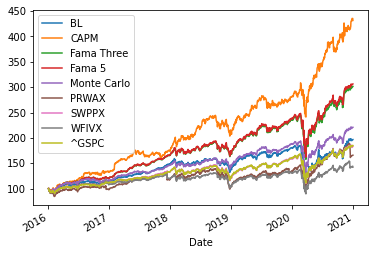

In [20]:
display(BL_cum_ret)
display(F3_cum_ret)
pfcr = pd.concat([BL_cum_ret, CAPM_cum_ret, F3_cum_ret, F5_cum_ret, MC_cum_ret], axis=1)
display(pfcr)
pfcr.columns = ["BL", "CAPM", "Fama Three", "Fama 5", "Monte Carlo"]
pfcr = pd.DataFrame(pfcr)
newdf = pfcr.join(compare_port)

newdf.plot()

In [21]:
data = yf.download(tickers, start = start, end = end, threads = False)
data = data.loc[:,('Close', slice(None))]
data.columns = tickers

BL_port_ret = data
CAPM_port_ret = data
F3_port_ret = data
F5_port_ret = data
MC_port_ret = data

for tick in tickers:
    try:BL_port_ret.loc[:,tick] = data.loc[:,tick] * BL_Weights.loc[tick]
    except:pass
    try:CAPM_port_ret.loc[:,tick] = data.loc[:,tick] * CAPM_Weights.loc[tick].values
    except:pass
    try:F3_port_ret.loc[:,tick] = data.loc[:,tick] * F3_Weights.loc[tick].values
    except:pass
    try:F5_port_ret.loc[:,tick] = data.loc[:,tick] * F5_Weights.loc[tick].values
    except:pass
    try:MC_port_ret.loc[:,tick] = data.loc[:,tick] * MC_Weights.loc[tick].values
    except:pass

#BL_port_ret = BL_port_ret.mean(axis=1)
#CAPM_port_ret = CAPM_port_ret.mean(axis=1)
#F3_port_ret = F3_port_ret.mean(axis=1)
#F5_port_ret = F5_port_ret.mean(axis=1)
#MC_port_ret = MC_port_ret.mean(axis=1)
BL_port_ret = pd.DataFrame(BL_port_ret.mean(axis=1))
CAPM_port_ret = pd.DataFrame(CAPM_port_ret.mean(axis=1))
F3_port_ret = pd.DataFrame(F3_port_ret.mean(axis=1))
F5_port_ret = pd.DataFrame(F5_port_ret.mean(axis=1))
MC_port_ret = pd.DataFrame(MC_port_ret.mean(axis=1))

BL_port_ret.columns = ["Close"]
CAPM_port_ret.columns = ["Close"]
F3_port_ret.columns = ["Close"]
F5_port_ret.columns = ["Close"]
MC_port_ret.columns = ["Close"]


BL_diff = pd.DataFrame(BL_port_ret.pct_change().dropna())
CAPM_diff = pd.DataFrame(CAPM_port_ret.pct_change().dropna())
F3_diff = pd.DataFrame(F3_port_ret.pct_change().dropna())
F5_diff = pd.DataFrame(F5_port_ret.pct_change().dropna())
MC_diff = pd.DataFrame(MC_port_ret.pct_change().dropna())

BL_diff.columns = ["Close"]
CAPM_diff.columns = ["Close"]
F3_diff.columns = ["Close"]
F5_diff.columns = ["Close"]
MC_diff.columns = ["Close"]


[*********************100%***********************]  48 of 48 completed


In [22]:
import riskfolio.Reports as rp

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


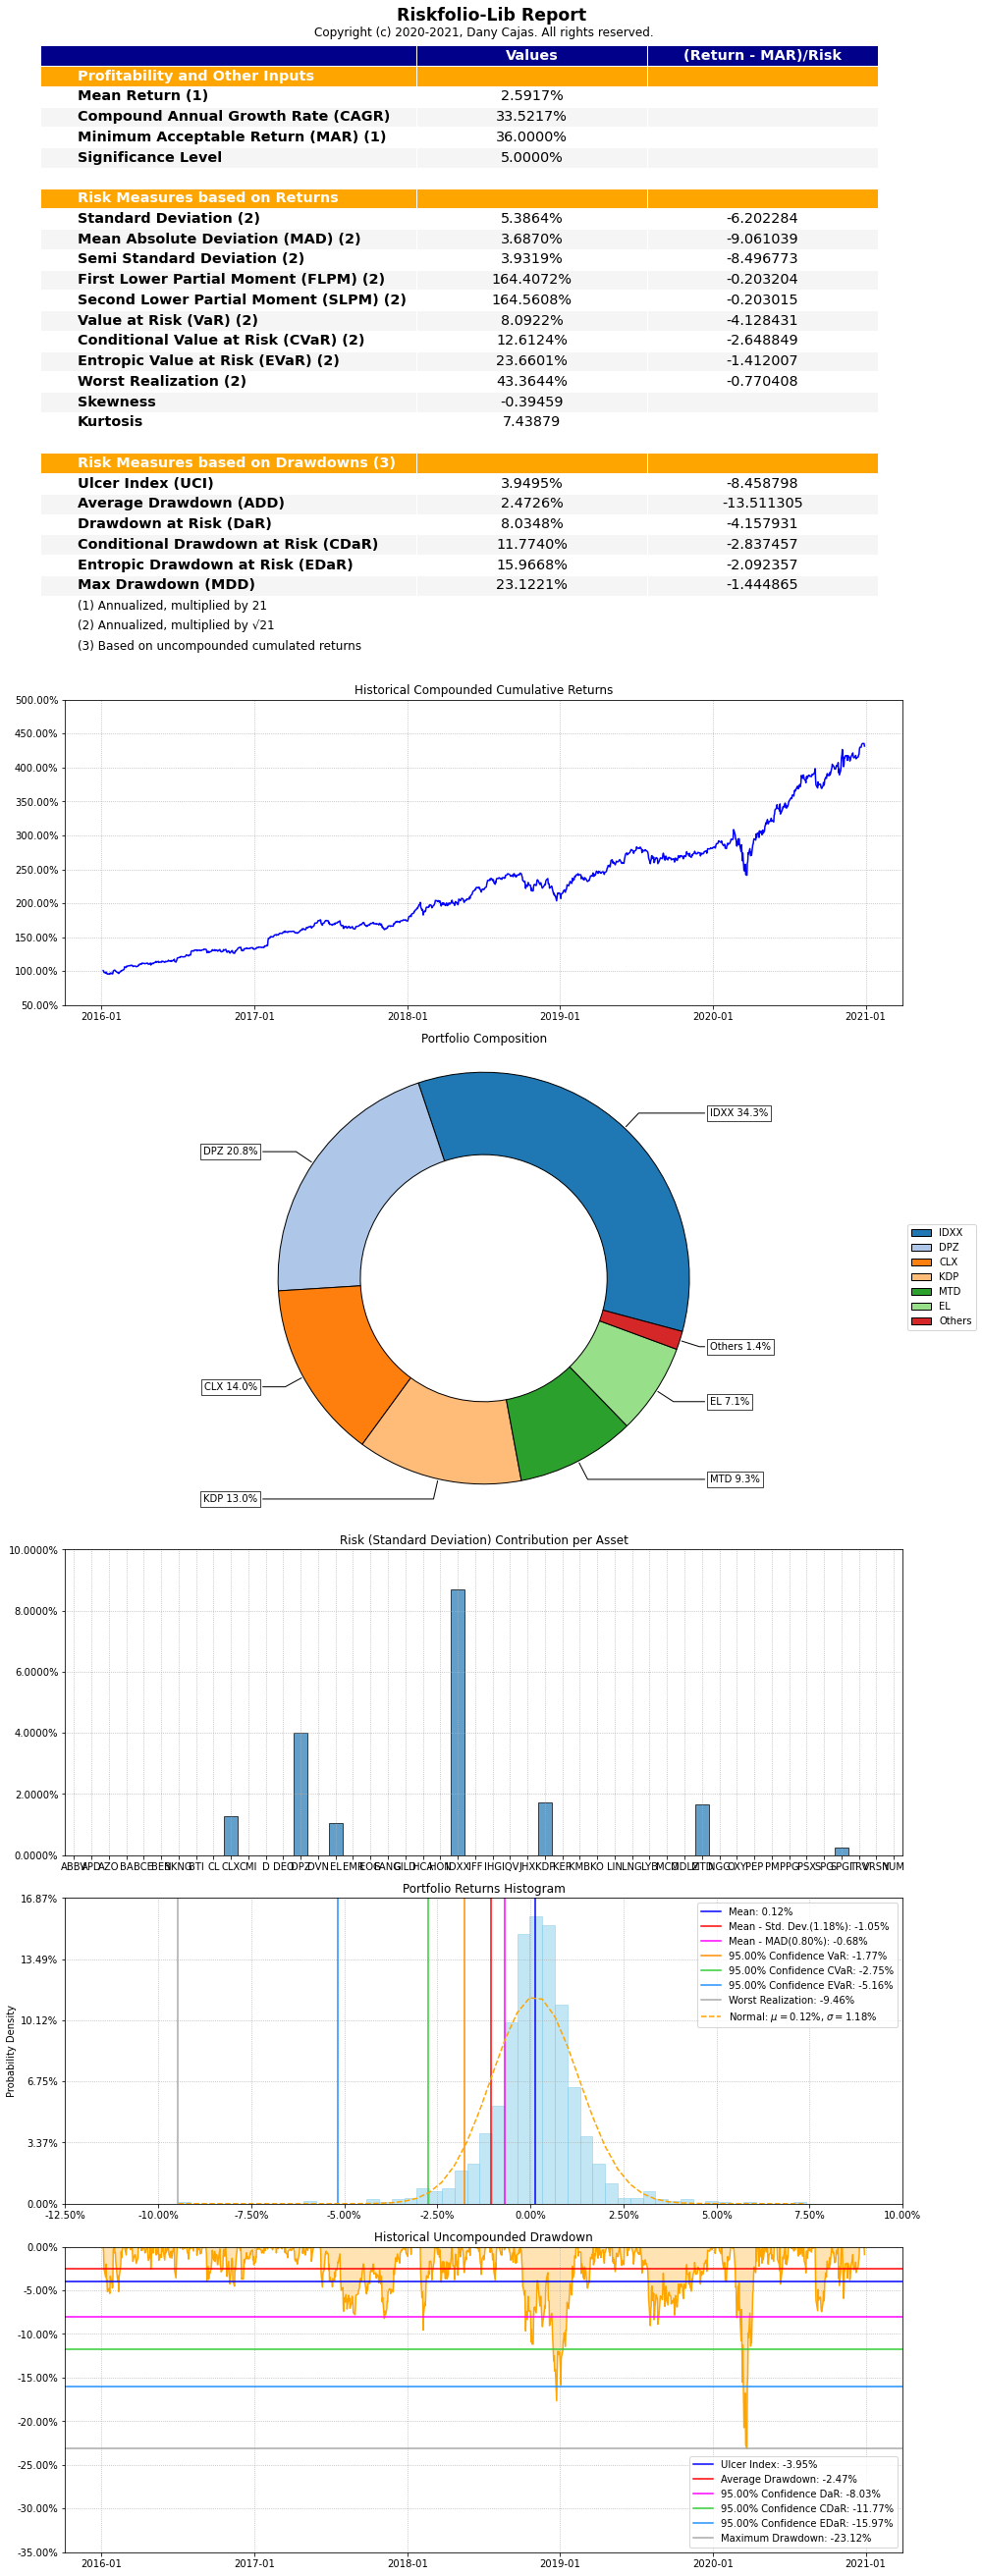

In [36]:
ax_report = rp.jupyter_report(port_diff, w=CAPM_Weights, rm='MV', rf=0.36, t_factor = 21)

In [27]:
BL_Weights = pd.DataFrame(BL_Weights)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


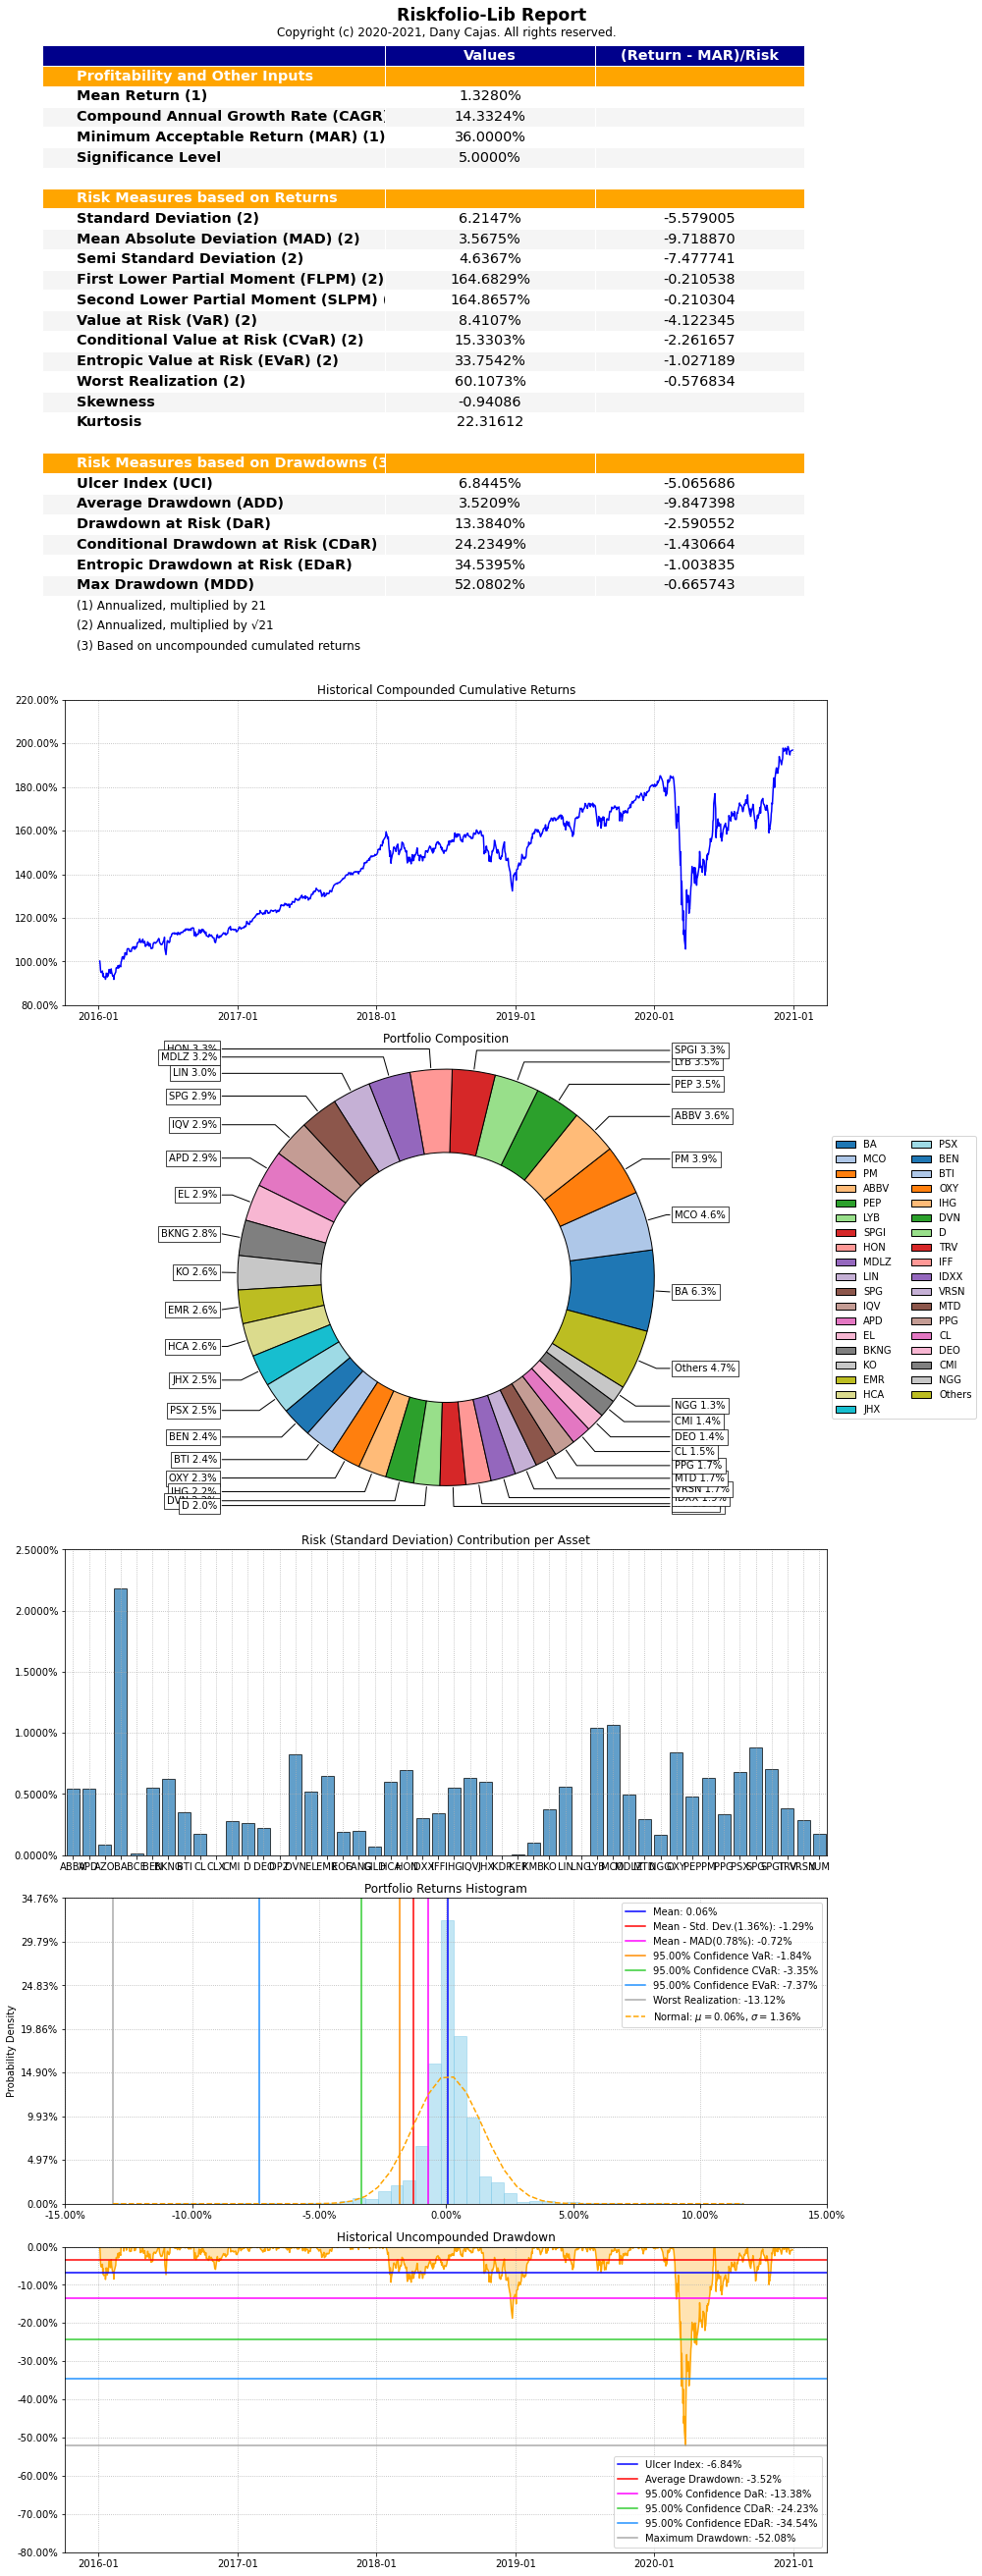

In [32]:
ax_report = rp.jupyter_report(port_diff, w=BL_Weights, rm='MV', rf=0.36, t_factor = 21)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


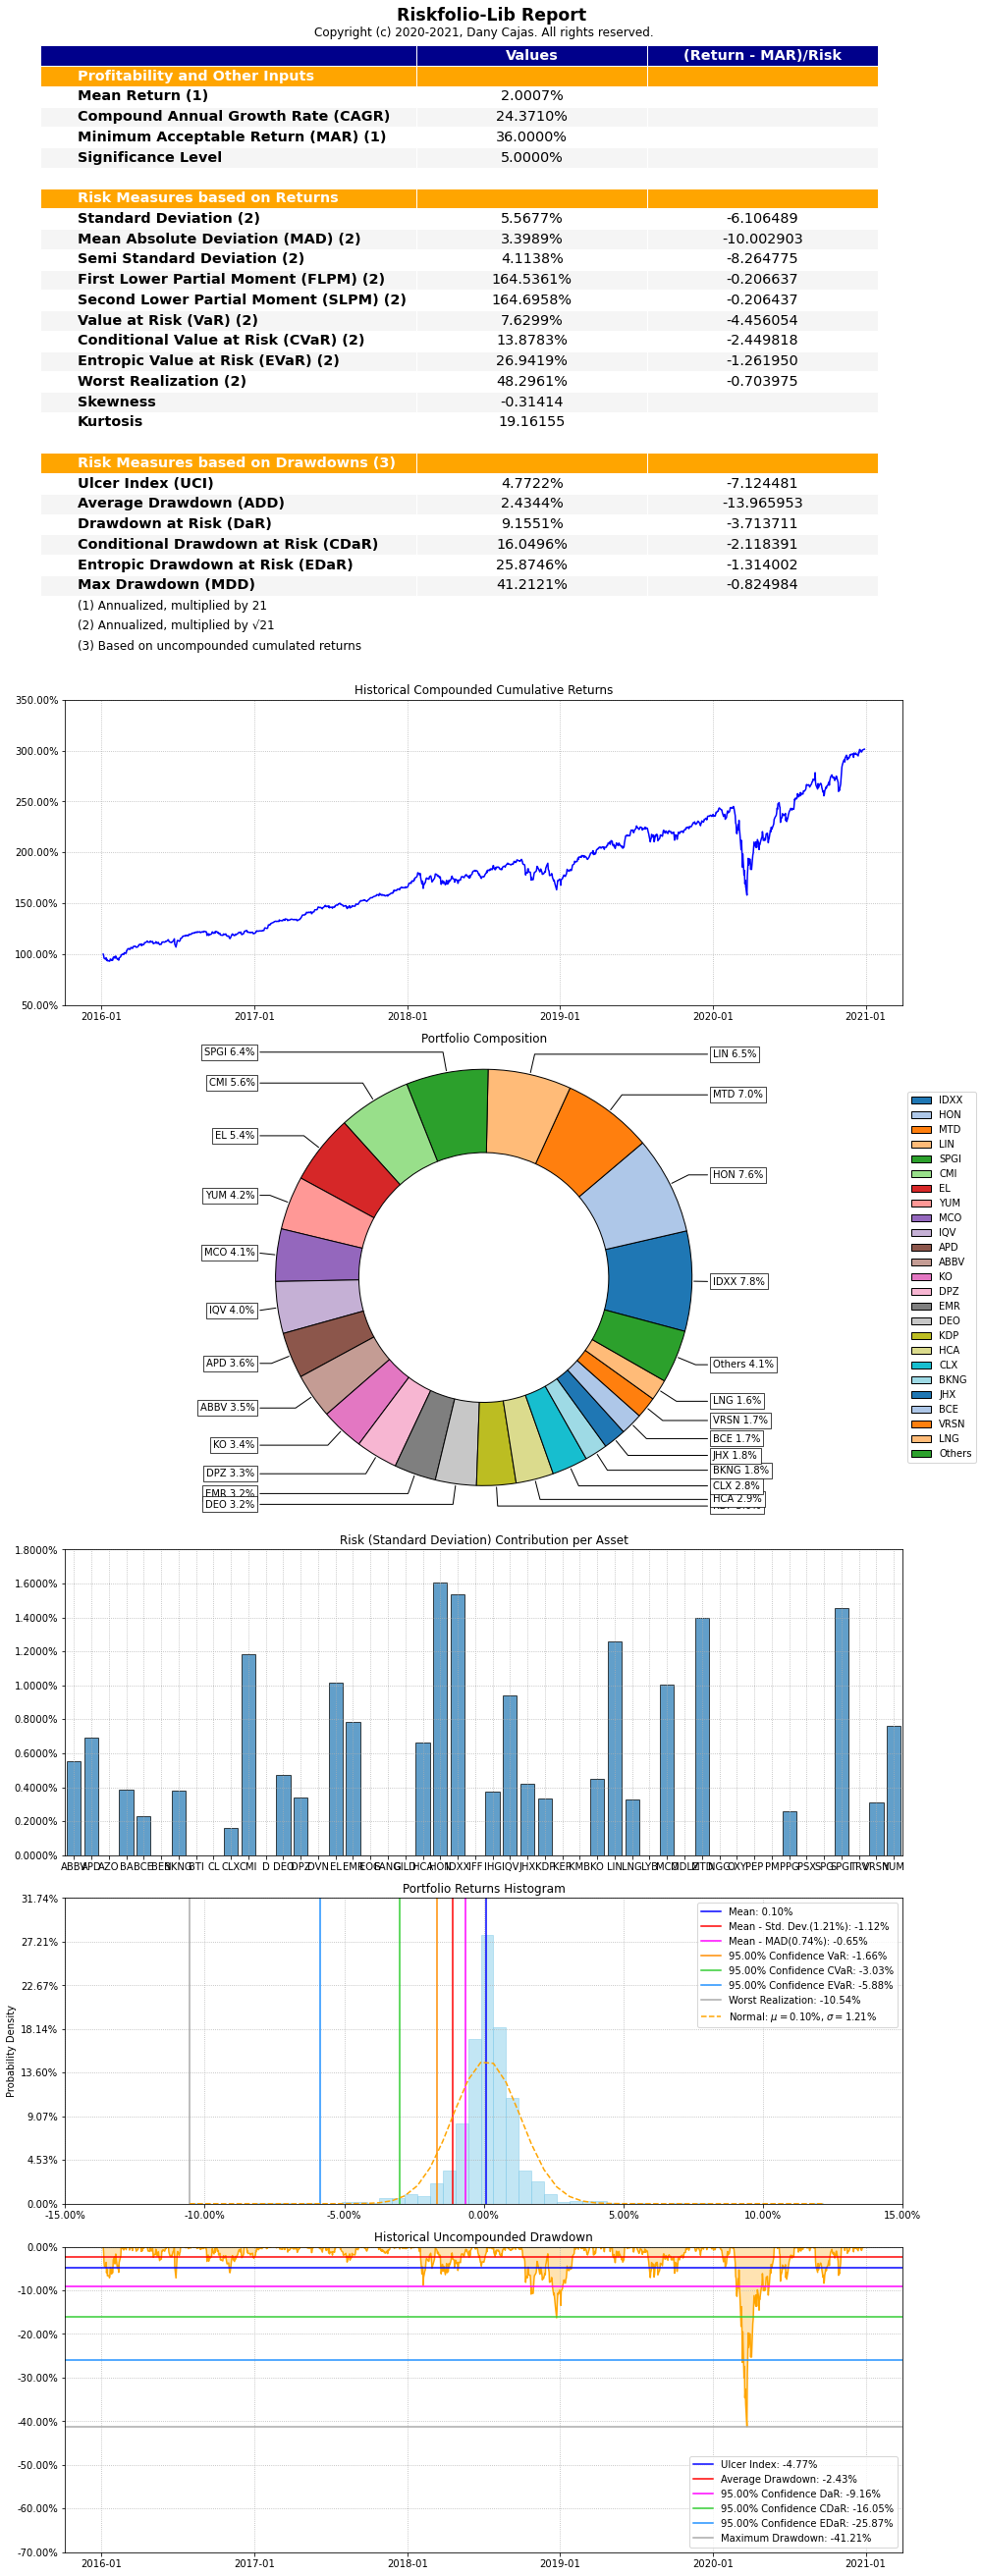

In [33]:
ax_report = rp.jupyter_report(port_diff, w=F3_Weights, rm='MV', rf=0.36, t_factor = 21)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


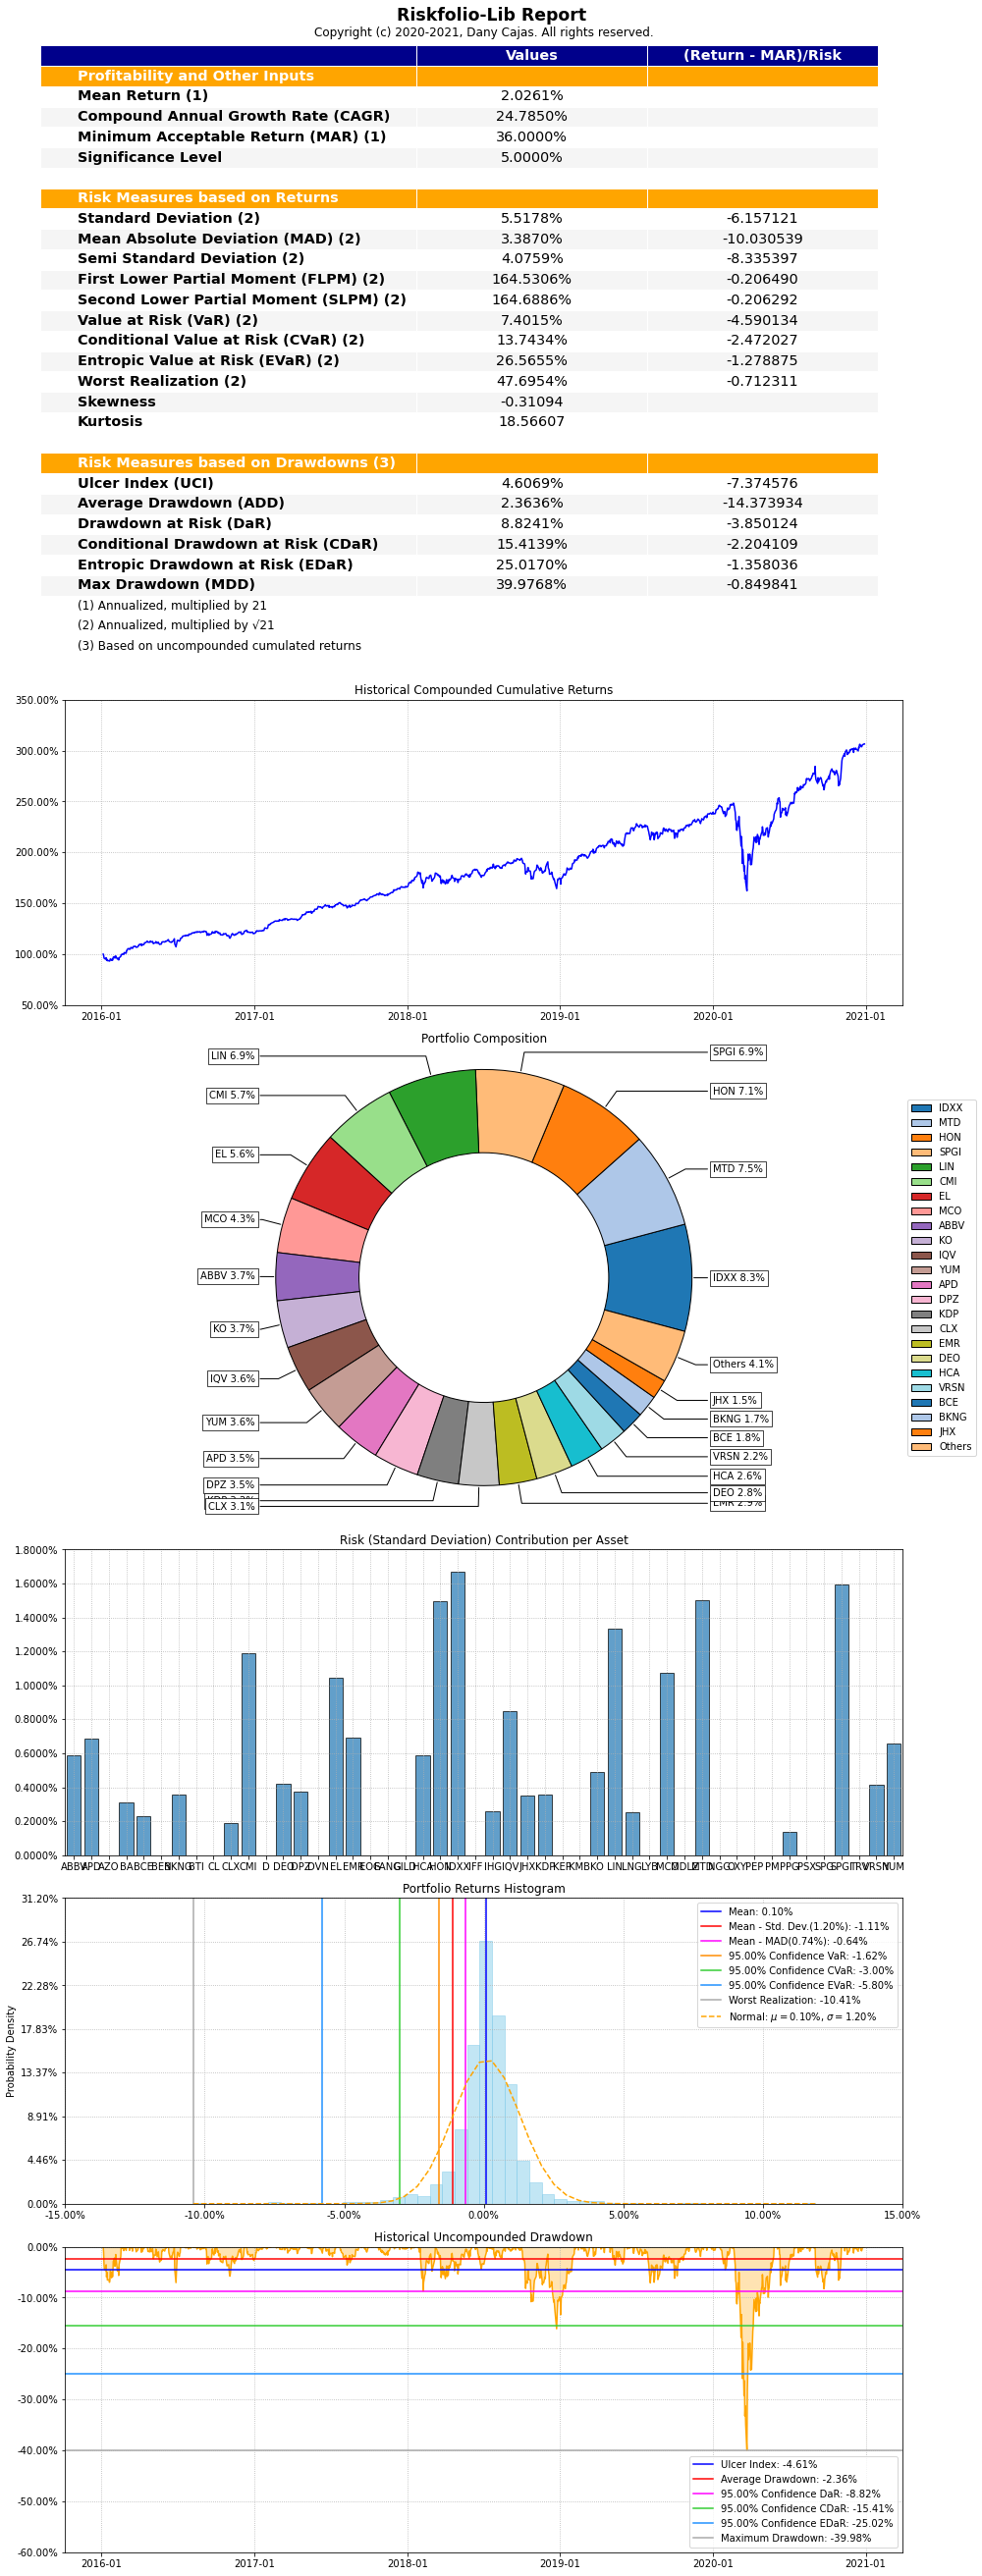

In [34]:
ax_report = rp.jupyter_report(port_diff, w=F5_Weights, rm='MV', rf=0.36, t_factor = 21)

\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
\\userFS\joa512\w2k\Applications\Python\Python38\site-packages\riskfolio\RiskFunctions.py:348: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


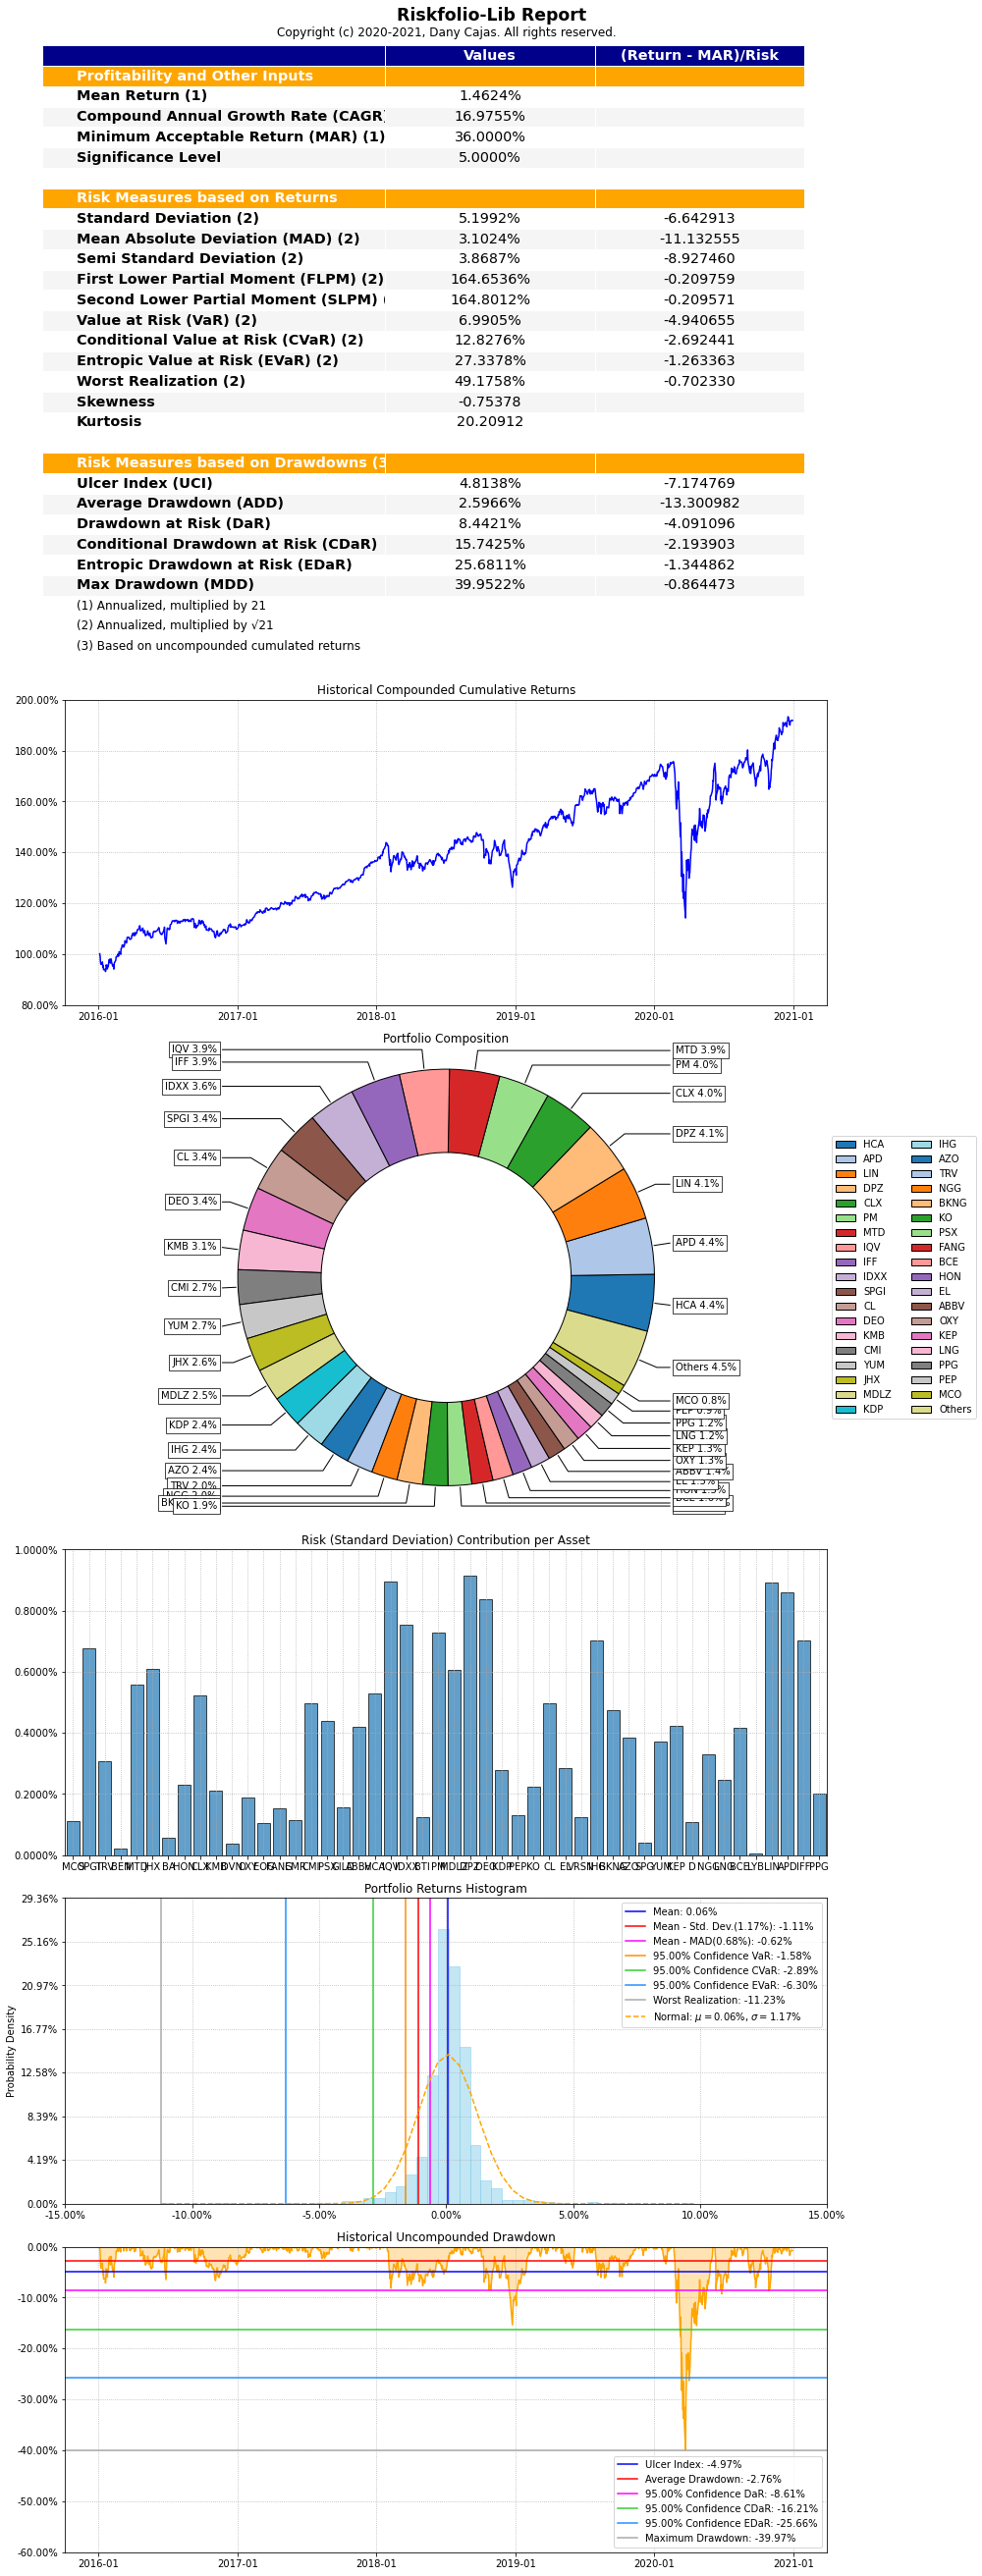

In [35]:
ax_report = rp.jupyter_report(port_diff, w=MC_Weights, rm='MV', rf=0.36, t_factor = 21)

##### 